# Trend in Melt Onset Date

This notebook demonstrates how to read NASA passive microwave melt onset data; regrid this data to EASE-Grid; and calculate linear trends with p-values.  I use the NetCDF version of the data.  Data were downloaded from https://earth.gsfc.nasa.gov/cryo/data/arctic-sea-ice-melt.  

I use [`xarray`](http://xarray.pydata.org/en/stable/index.html) to read the data.  This is a library for working with N-dimensional data arrays that is especially useful for working with NetCDF-type data.  The original melt onset data are in the NSIDC North Polar Stereographic projection.  The data are reprojected to the Equal Area Scaleable Earth Grid (EASE-Grid) using `rasterio`.  _Add more about calculating the linear trend_ 

In [1]:
import os
import glob

import numpy as np
import xarray as xr
import rasterio.crs as rcrs

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


DATAPATH = "../data/Melt_Onset"  # Change this path to the local directory where melt onset data is located

## Read the data
`xarray` reads NetCDF directly with the `open_dataset` method.  This produces a NetCDF-type Dataset object that contains four variables; Earlymelt, Melt, Earlyfreeze, and Freeze.  Each variabe has `x` and `y` dimensions.  Ideally, there should be coordinate variables in projected coordinates and latitude and longitude grids as well.  Clicking on the page icon to the right of each variable reveals the variable attributes.  The "disk stack" icon gives the length of the variable and the data type.  The Attributes below are global attributes of the file.  

In [2]:
ds = xr.open_dataset(os.path.join(DATAPATH, '1979731smeltfreeze.nc'))
ds

<xarray.Dataset>
Dimensions:      (x: 304, y: 448)
Dimensions without coordinates: x, y
Data variables:
    Earlymelt    (y, x) int16 ...
    Melt         (y, x) int16 ...
    Earlyfreeze  (y, x) int16 ...
    Freeze       (y, x) int16 ...
Attributes:
    Melt Version:     731s
    Year:             1979
    Production_Date:  Thu Oct 29 17:02:49 2020

Variables can be accessed in two ways.

In [3]:
ds.Earlymelt

<xarray.DataArray 'Earlymelt' (y: 448, x: 304)>
[136192 values with dtype=int16]
Dimensions without coordinates: y, x
Attributes:
    long_name:    Passive Microwave Sea Ice Early melt
    units:        Day of Year
    description:  Early melt is the first observed strong melt signature, tho...
    Valid_Range:  75-210
    Key:          Negative values are flags for where melt / freeze could not...

In [4]:
ds["Earlymelt"]

<xarray.DataArray 'Earlymelt' (y: 448, x: 304)>
[136192 values with dtype=int16]
Dimensions without coordinates: y, x
Attributes:
    long_name:    Passive Microwave Sea Ice Early melt
    units:        Day of Year
    description:  Early melt is the first observed strong melt signature, tho...
    Valid_Range:  75-210
    Key:          Negative values are flags for where melt / freeze could not...

In Jupyter notebooks, both methods produce a nicely-formatted snipped image of the DataArray.  These arrays should look familiar because they are just `numpy` arrays objects.  The attributes are also displayed.  If you want to assign values to a DataArray you can only use the `ds["Earlymelt"]` version.

Like other python objects, `Datasets` and `DataArrays` have attributes and methods.  In some cases, an attribute is available for or a method will operate on both a `Dataset` and a `DataArray`.  However, in other cases only DataArrays or Datasets will have given attributes or methods.  See http://xarray.pydata.org/en/stable/data-structures.html for further details.  For example, each DataArray has a shape and data-type attribute but these attributes are not available for a Dataset.

In [5]:
ds.Melt.shape

(448, 304)

In [6]:
ds.Melt.dtype

dtype('int16')

However, `min`, `max`, `mean` methods all work for both Datasets and DataArrays.

In [7]:
ds.Melt.min()

<xarray.DataArray 'Melt' ()>
array(-10, dtype=int16)

Each DataArray has a plot method, that produces a `pcolormesh` of a 2D array or a lineplot of a 1D array.  A histogram is plotted for DataArrays with more than two dimensions.

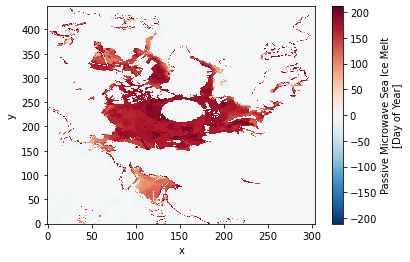

In [8]:
ds.Melt.plot()

`xarray.concat` can be used to load multiple files to create a 3D data cube, which is what I want for trend analysis. In some cases you can use `xarray.open_mfdataset` but this can result in errors if datasets are not well behaved.

In the cell below, I define two functions `process_one`, which read a single netcdf file, creates a new dimension year and sets non-valid values to NaNs.  It also sets cells in Earlymelt and Earlyfreeze with zero to the same value the equivalent Melt and Freeze grids.  `expand_dims` is used to add the `year` dimension.  The year is taken from the filename.  The resulting Datasets have dimensions `(year, x, y)`.

In `read_files` I call `process_one` within a list comprehension (`[process_one(f) for f in sorted(filelist)]`) to produce a list of Datasets.  These Datasets are concatenated along the `year` dimensions.

In [9]:
def process_one(f):
    """Processes a single melt onset file: adds a year as the first dimension, sets values < 0 to missing and 
    Earlymelt and Earlyfreeze zero values to Melt and Freeze
    :returns: xarray.DataArray
    """
    year = [int(os.path.basename(f)[0:4])]
    ds = xr.open_dataset(f)  
    ds = ds.expand_dims({"year": year}, 0)  # Adds year as first dimension
    ds = ds.where(ds > 0)  # -ve values are invalid
    ds["Earlymelt"] = ds["Earlymelt"].where(ds["Earlymelt"] != 0, ds.Melt)  # zero indicates Earlymelt onset date same as Melt onset date
    ds["Earlyfreeze"] = ds["Earlyfreeze"].where(ds["Earlyfreeze"] != 0, ds.Freeze)  # ditto for Earlyfreeze
    return ds
    

def read_files(fileslist):
    """Concatenates melt onset files along a new dimension 'year'.
    
    years are extracted from filenames.
    
    :returns: xarray.Dataset    
    """
    return xr.concat([process_one(f) for f in sorted(filelist)], dim="year")


filelist = glob.glob(os.path.join(DATAPATH, "*meltfreeze.nc"))
ds = read_files(filelist)
ds

<xarray.Dataset>
Dimensions:      (x: 304, y: 448, year: 41)
Coordinates:
  * year         (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019
Dimensions without coordinates: x, y
Data variables:
    Earlymelt    (year, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    Melt         (year, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    Earlyfreeze  (year, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    Freeze       (year, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Melt Version:     731s
    Year:             1979
    Production_Date:  Thu Oct 29 17:02:49 2020

So now we have a `xarray` Dataset for containing days of year of Earlymelt, Melt, Earlyfreeze and Freeze onset dates for 1979 to 2019.  Each variable has three dimensions; x, y and year.  However, only year has coordinates.  Ideally, x and y should have coordinates in meters in the NSIDC North Polar Stereographic  projection.   

In [10]:
#TBD

Finally, we calculate the linear trend in Melt onset date for each pixel.  Currently, there is no linear trend function in xarray, so I use the `groupby` and `apply` methods with the `scipy.stats.linregress` function from the `scipy` library.

In [11]:
def _linear_trend(x):
    import scipy.stats
    b1, b0, r, p, se = scipy.stats.linregress(x.year, x)
    #return xr.DataArray(b1)
    return xr.Dataset({'b1': b1,
                       'b0': b0,
                       'r': r,
                       'p': p,
                       'se': se})

def xr_trend(da, dim='time'):
    if dim not in da.dims:
        print ('Not {:s} dimension in DataArray'.format(dim))
        return
    
    stack_dims = [d for d in da.dims if d != dim]
    dastack = da.stack(allpoints=stack_dims)
    
    trend = dastack.groupby('allpoints').apply(_linear_trend)
    
    return trend.unstack('allpoints')  


In [12]:
melt_trend = xr_trend(ds.Melt, dim="year")
melt_trend

<xarray.Dataset>
Dimensions:  (x: 304, y: 448)
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
Data variables:
    b1       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    b0       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    r        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    p        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    se       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

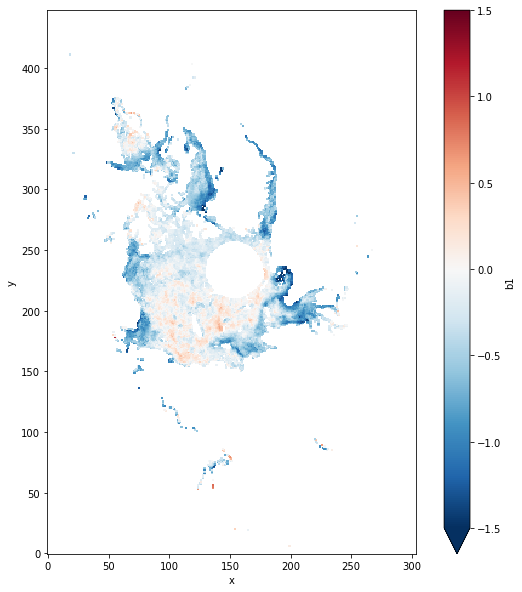

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")
#ax.set_title('Trend in Melt Onset (days/year)')
melt_trend.b1.plot(ax=ax, vmin=-1.5, vmax=1.5, cmap='RdBu_r')
fig.savefig("melt_onset_trend.png")

## A quick test of `temp*time`

In [14]:
temp = xr.DataArray(np.arange(9).reshape(3,3), coords=[np.arange(3),np.arange(3)], dims=['x','y'])
temp

<xarray.DataArray (x: 3, y: 3)>
array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])
Coordinates:
  * x        (x) int64 0 1 2
  * y        (y) int64 0 1 2

In [15]:
time = xr.DataArray(np.arange(4), coords=[np.arange(4)], dims=['time'])
time

<xarray.DataArray (time: 4)>
array([0, 1, 2, 3])
Coordinates:
  * time     (time) int64 0 1 2 3

In [16]:
temp*time

<xarray.DataArray (x: 3, y: 3, time: 4)>
array([[[ 0,  0,  0,  0],
        [ 0,  1,  2,  3],
        [ 0,  2,  4,  6]],

       [[ 0,  3,  6,  9],
        [ 0,  4,  8, 12],
        [ 0,  5, 10, 15]],

       [[ 0,  6, 12, 18],
        [ 0,  7, 14, 21],
        [ 0,  8, 16, 24]]])
Coordinates:
  * x        (x) int64 0 1 2
  * y        (y) int64 0 1 2
  * time     (time) int64 0 1 2 3